In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import ipywidgets as widgets
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Sample from distribution and sum results
Choose and visualize a distribution to draw from, including continous distributions. 

In [2]:
#default values
N = 1000
m = 1000

#can be changed into a valid probabilty-value pair
#E = 3
#values = np.arange(E)
#p = np.ones(E)/E
values = np.arange(5)
p = np.array([0.4,0.2,0.1,0.2,0.1])

In [3]:
class Distribution():
    def __init__(self, values, p, df = 0.01, range_ = 3.2):
        self.p = p
        self.values = values
        self.f = np.arange(-range_,range_,df).reshape((-1,1))

    def sample_from_distribution(self,m,N):
        distribution = np.random.choice(self.values, (m,N), p = self.p)
        return distribution
    
    def get_mean(self):
        return np.dot(self.values,self.p)
    
    def get_std(self):
        return np.sqrt(np.dot((self.values - self.get_mean())**2,self.p))
    
    def plot_samples(self,N,m):
        samples = self.sample_from_distribution(int(m),int(N))
        random_sum = np.sum(samples, axis = -1)
            
        sns.histplot(random_sum, kde = True)
    
    def plot_distribution(self):        
        plt.bar(self.values, self.p, width = (self.values[1] - self.values[0]) * 0.95)
        plt.show()  
        
    def get_limit_fourier_transform(self):
        F_p = np.exp(-2*(np.pi**2)*(self.f**2))
        return np.squeeze(F_p)

    def get_fourier_transform(self,N):
        p = self.p.reshape(-1,1)
        values = self.values.reshape(1,-1)
        f_hat = np.dot(np.cos(2*np.pi*values*self.f/np.sqrt(N)),p)
        return np.squeeze(f_hat**N)

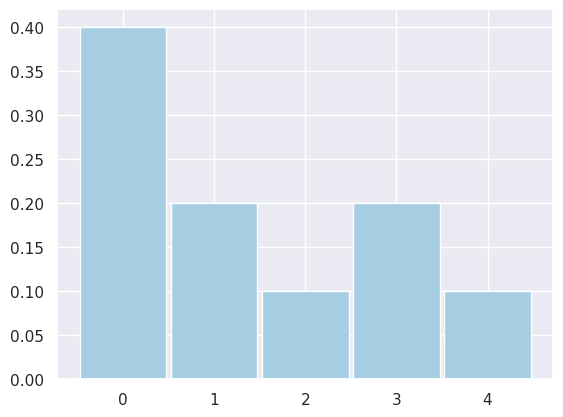

In [4]:
sns.set(style = 'darkgrid', context = 'notebook', palette = 'Paired')
dist = Distribution(values,p)

dist.plot_distribution()

In [5]:
sns.set(palette = 'Dark2')
def interactive_plot_samples(N,m,dist):
    fig, ax = plt.subplots()
    dist.plot_samples(N,m)

In [6]:
interact(
    lambda N,m: interactive_plot_samples(N,m,dist), 
    N = widgets.FloatLogSlider(base = 10, min = np.log10(1), max = 3, value = N), 
    m = widgets.FloatLogSlider(base = 10, min = 1, max = 4, value = m)
)

interactive(children=(FloatLogSlider(value=1000.0, description='N', max=3.0), FloatLogSlider(value=1000.0, des…

<function __main__.<lambda>(N, m)>

## Normalize Distribution

In [7]:
class NormalizedDistribution(Distribution):
    def __init__(self, values, p, df = 0.01):
        super().__init__(values, p, df)
        self.p = p
        self.values = self.normalize(values, p)
        
    def normalize(self, values, p):
        mean = self.get_mean()
        std = self.get_std()
    
        values_norm = (values - mean)/std
    
        return values_norm

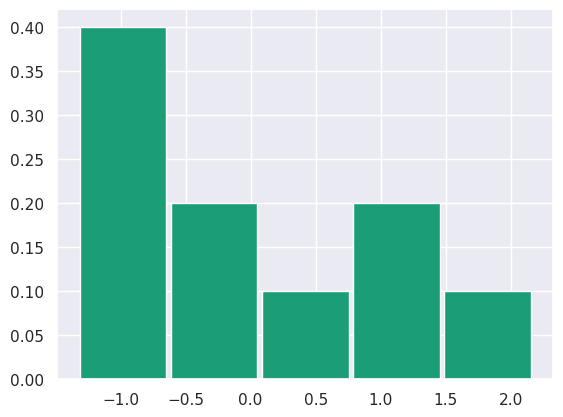

In [8]:
normalized_dist = NormalizedDistribution(values,p)

normalized_dist.plot_distribution()

## Using The Fourier Transform Convolution Property
For a sum of random variables to converge it must satisfy have finite mean, variance, and skewness. Then it can be converted to the following: 
<br>
$$
    \int_{-\infty}^{\infty} p_{1}(x) dx = 1 \qquad \int_{-\infty}^{\infty} x p_{1}(x) dx = 0 \qquad \int_{-\infty}^{\infty} x^2 p_{1}(x) dx = 1 \qquad \left| \int_{-\infty}^{\infty} x^3 p_{1} (x) dx \right| < \infty \iff \int_{-\infty}^{\infty} |x|^3 p_{1} (x) dx < \infty
$$
<br>
$$
    P(X + Y = x) = [ p_{X} \ast p_{Y} ] (x) \qquad Var(X+Y) = Var(X) + Var(Y)
$$
<br>
$$
    P_{N} = (P(X_{1} + X_{2} + \cdots + X_{N}) = [p_{1}*\cdots*p_{N}](x) \qquad Var(X_{1} + X_{2} + \cdots + X_{N}) = N
$$
<br>
Because the probabilty is broken down into convolutions its a good idea to apply the fourier transform to simplify the expression.
<br>
$$
    \mathcal{F}[P_{N}] = (\mathcal{F}[p_{1}])^N \qquad \mathcal{F}[p_{1}] = \hat{f}(f) = \hat{f}(0) + \hat{f}'(0) f + \frac{1}{2} \hat{f}''(0) f^2 + \big| \hat{f}^{(3)} \big| O(f^3)
$$
<br>
We can get information about $\hat{f}$ from its taylor expansion because it represents the moments of the distribution.
<br>
$$
    \hat{f}(0) = \int_{-\infty}^{\infty} p_{1}(x) dx = 1 \qquad \hat{f}'(0) = -2\pi i \int_{-\infty}^{\infty} x p_{1}(x) dx = 0 \qquad \hat{f}''(0) = -4\pi^2 \int_{-\infty}^{\infty} x^2 p_{1}(x) dx = -4 \pi^2  \qquad \big| \hat{f}^{(3)} \big| <= \int_{-\infty}^{\infty} |x|^3 p_{1} (x) dx
$$
<br>
$$
    \hat{f}(f) = \left[ 1 - 2 \pi^2 f^2 + O(f^3) \right]^N \qquad p_N = Normalize(P_N) = \sqrt{N} P_N(\sqrt{N} x)
$$
<br>
$$
    \mathcal{F}[p_N] = \mathcal{F}[\sqrt{N}P_N(\sqrt{N} x)] = \hat{f}(\frac{f}{\sqrt{N}}) = \left[ 1 + \frac{-2 \pi^2 f^2}{N} + O\left( \frac{f^3}{N^{\frac{3}{2}}} \right) \right]^N
$$
<br>
$$
    \mathcal{F}[p] = \lim_{N \to \infty} \mathcal{F}[p_N] = \lim_{N \to \infty} \left[ 1 + \frac{-2 \pi^2 f^2}{N} + O\left( \frac{f^3}{N^{\frac{3}{2}}} \right) \right]^N = e^{-2 \pi^2 f^2}
$$
<br>
$$
    p(x) = \mathcal{F}^{-1}[\mathcal{F}[p]] = \int_{-\infty}^{\infty} e^{-2 \pi^2 f^2 +2 \pi i f x} df = e^{- \frac{1}{2} x^2} \int_{-\infty}^{\infty} e^{ -2 \pi^2 ( f -\frac{i}{2 \pi} x)^2 } df = e^{- \frac{1}{2} x^2} \int_{\gamma} e^{-2 \pi^2 z^2} dz
$$
<br>
From here using properties of countor integrals we can simplify the integral into a easily solvable form.
<br>
$$
    \int_{\gamma} e^{-2 \pi^2 z^2} dz + \int_{\Gamma} e^{-2 \pi^2 z^2} dz = 0 \qquad \Gamma: z = f, f: \infty \rightarrow - \infty
$$
<br>
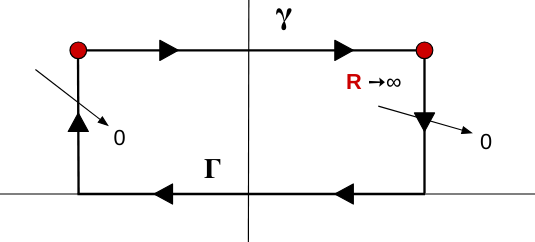
<br>
$$
    p(x) = e^{- \frac{1}{2} x^2} \int_{-\infty}^{\infty} e^{-2 \pi^2 f^2} df = \frac{1}{\sqrt{2\pi}} e^{- \frac{1}{2} x^2}
$$

In [9]:
def fourier_plots(N, dist):
    fig, ax = plt.subplots()
    f = np.squeeze(normalized_dist.f)

    F_p = normalized_dist.get_limit_fourier_transform()
    F_p_N = normalized_dist.get_fourier_transform(N)
    
    sns.lineplot(x = f, y = F_p, ax = ax, label = 'Fourier Transform Limit', linewidth = 2, linestyle = 'dashed', color = 'g')
    sns.lineplot(x = f, y = F_p_N, ax = ax, label = 'Fourier Transform', color = 'b')
    plt.legend(loc='best')
    plt.show()

interact(lambda N: fourier_plots(N,dist), N = widgets.IntSlider(value = 2, min = 1, max = 100))

interactive(children=(IntSlider(value=2, description='N', min=1), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(N)>

In [10]:
df = 0.001
def all_together(N,m,dist):
    fig, axs = plt.subplots(nrows = 3)
    
    normalized_dist = NormalizedDistribution(dist.values,dist.p)
    samples = dist.sample_from_distribution(int(m),int(N))
    random_sum = np.sum(samples, axis = -1)
            
    f = np.squeeze(normalized_dist.f)
    F_p_N = normalized_dist.get_fourier_transform(N)
    
    values_N = f*dist.get_std()*np.sqrt(N) + dist.get_mean()*N
    p_N = np.exp(-((values_N-dist.get_mean()*N)**2)/(2*N*(dist.get_std())**2))/(np.sqrt(2*N*np.pi)*dist.get_std())
    
    sns.barplot(x = dist.values, y = dist.p, ax = axs[0], palette = 'pastel', label = 'Initial Distribution')
    sns.lineplot(x = f, y = F_p_N, ax = axs[1], label = 'Normalized Fourier Transform')
    sns.lineplot(x = values_N, y = p_N, ax = axs[2], label = 'Distribution', color = 'b')  
    sns.histplot(random_sum, ax = axs[2], stat = 'density', color = 'lightblue', label = 'Sample Distribution')
    plt.tight_layout()

In [11]:
interact(lambda N,m: all_together(N,m, dist), 
        N = widgets.IntSlider(value = 2, min = 1, max = 100), 
    m = widgets.IntSlider(min = 50, max = 5000, value = m)
        )

interactive(children=(IntSlider(value=2, description='N', min=1), IntSlider(value=1000, description='m', max=5…

<function __main__.<lambda>(N, m)>